<a href="https://colab.research.google.com/github/tianygoulart/Machine-Leaning/blob/main/%5BIGTI%5D_SDE_Aula_Interativa_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sistemas de Recomendação - Aula Interativa 2**

## Latent Factors

- [Prof. Matheus Mendonça](https://www.linkedin.com/in/matheusmendonca/)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Singular Value Decomposition - SVD

O SVD é uma técnica de decomposição de matrizes definido da seguinte maneira:

$$R_{m \times n} = U_{m \times k} \Sigma_{k \times k} (V_{n \times k})^T,$$

onde:

* $R$: matriz de entrada ou matriz de avaliações
  * matriz $m \times n$ (e.g. $m$ usuários e $n$ filmes)
* $U$: vetores singulares à esquerda
  * matriz $m \times k$ (e.g. $m$ usuários e $k$ componentes)
* $\Sigma$: valores singulares
  * matriz diagonal $k \times k$, sendo $k$ o rank da matriz (e.g. intensidade de cada componente, $k$ **fatores latentes**)
* $V$: vetores singulares à direita
  * matriz $n \times k$ (e.g. $n$ itens e $k$ componentes)

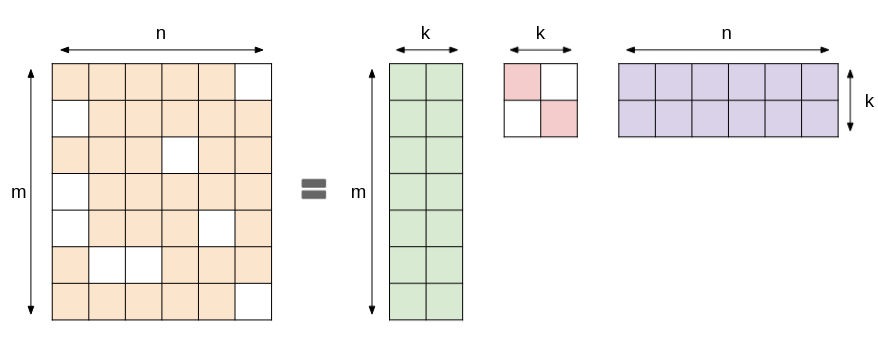

Diversas aplicações, entre elas está a **redução de dimensionalidade**:

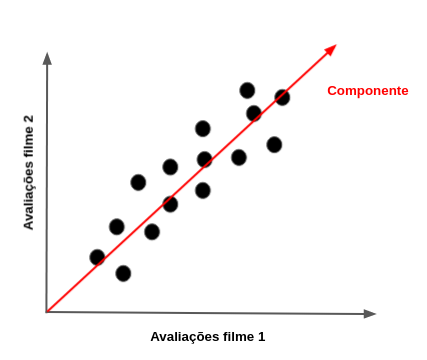

## Recomendação como um problema de otimização

**Ideia geral**: escrever a matriz de avaliações como:

$$R_{m \times n} \approx P_{m \times k} \cdot Q_{k \times n},~k << m,n.$$

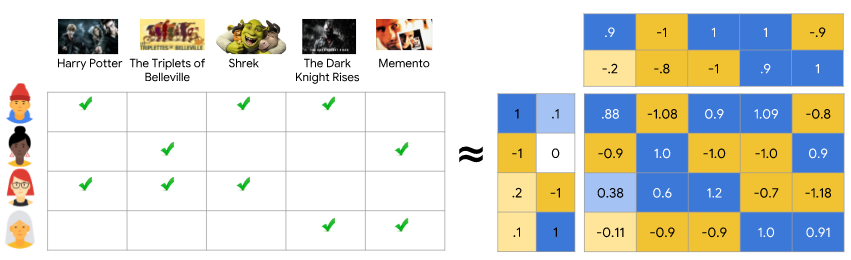

Usar a ideia do SVD, mas adaptado para o contexto de recomendação no qual a matriz R é esparsa! 

A predição da avaliação do usuário $i$ para o item $j$ é então dada por:

$$\hat{R}_{i,j} = P_i \cdot Q_j.$$

Formulações mais elaboradas utilizam fatores de compensação de viés de avaliação de usuários ($b_i$) e itens ($b_j$), além de fatores globais ($\mu$), fazendo com que a estimativa seja:

$$\hat{R}_{i,j} = \mu + b_i + b_j + P_i \cdot Q_j$$

**Desafio**: estimar os valores das matrizes $P$, $Q$, $b_i$ e $b_j$.

**Solução**: resolver via algoritmo de otimização:

$$\min_{P,Q,b_i,b_j} = \sum_{(i, j) \in R^+}(R_{i,j}-\hat{R}_{i,j})^2 + \lambda\left[b_i^2 + b_j^2 + \| P_i\|^2 + \|Q_j\|^2\right].$$

## Implementação

In [ ]:
class LatentFactor:
  """Classe que implementa a recomendação via decomposiçaõ de matrizes."""

  def __init__(self,
               ratings: np.array,
               test_size: float = 0.3,
               n_iter: int= 1000,
               lr: float = 0.001,
               p_reg: float = 0.001):
    """
      Args:
        ratings:  matriz (m x n) de avaliações.
        test_size: tamanho do conjunto de test.
        n_iter: número de iterações do algoritmo de otimização.
        lr: learning rate.
        p_reg: fator de regularização.
    """
    
    # atributos
    self.ratings = ratings
    self.p_reg = p_reg
    self.test_size = test_size
    self.n_iter = n_iter
    self.lr = lr

    # treino e test
    self.ratings_train = None
    self.ratings_test = None
    self.inz = None
    self.i_test = None

    # resultados
    self.P = None
    self.Q = None
    self.y_pred = None
    self.mu = None
    self.b_i = None
    self.b_j = None

  def train_test_split(self):
    """Realiza a divisão em conjunto de treino e de teste."""

    # treino 
    self.ratings_train = self.ratings.copy()

    # test_size% para treino
    i, j = np.where(self.ratings > 0)
    n = len(i)
    np.random.seed(10)
    i_test = np.random.choice(n, size=(int(self.test_size*n)))

    # zerando os valores
    self.ratings_train[i[i_test], j[i_test]] = 0.

    # teste
    self.ratings_test = self.ratings[i[i_test], j[i_test]]

    # índices
    self.inz = np.where(self.ratings_train > 0)
    self.i_test = i[i_test], j[i_test]

  def fit(self, verbose: bool = True):
    """Realiza o treinamento do algoritmo (encontrar os valors de P e Q)
    via gradiente descendente.
    """

    # divisão em treino e teste
    self.train_test_split()

    # palpite inical: SVD
    U, S, Vt = np.linalg.svd(self.ratings_train, full_matrices=False)
    self.P = U @ np.diag(S)
    self.Q = Vt

    # palpite inicial mu e bias
    self.mu = np.mean(self.ratings_train[self.inz])
    self.b_i = (np.sum(self.ratings_train, axis=1)/(np.sum(self.ratings_train>0, axis=1)+1e-6) - self.mu).reshape(-1, 1)
    self.b_j = np.sum(self.ratings_train, axis=0)/(np.sum(self.ratings_train>0, axis=0)+1e-6) - self.mu

    # acha o melhor número de fatores
    n_factors = self.best_n_factors(S)

    # log
    if verbose:
      print(f"Número de fatores latentes: {n_factors}")

    # retirando os fatores adicionais e deixando os n_factors
    self.P = self.P[:, :n_factors]
    self.Q = self.Q[:n_factors, :]

    # loop de otimização
    k = 0
    while k < self.n_iter:

      # log
      if verbose:
        print(f"Iteração {k+1} de {self.n_iter}...", end='')

      # atualiza learning rate
      lr = self.lr * 0.75**(np.floor(k/5))

      # iteração em cada observação
      for t in range(len(self.inz[0])):
        i, j = self.inz[0][t], self.inz[1][t]

        # calcula gradiente
        prediction = self.predict(i=i, j=j) 
        error = prediction - self.ratings_train[i, j]
        P_grad = error * self.Q[:, j].T + self.p_reg*self.P[i, :]
        Q_grad = self.P[i, :].T * error + self.p_reg*self.Q[:, j]
        bi_grad = error + self.p_reg*self.b_i[i, 0]
        bj_grad = error + self.p_reg*self.b_j[j]

        # atualiza matrizes
        self.P[i, :] = self.P[i, :] - lr*P_grad/(np.linalg.norm(P_grad)+1e-6)
        self.Q[:, j] = self.Q[:, j] - lr*Q_grad/(np.linalg.norm(Q_grad)+1e-6)
        self.b_i[i, 0] = self.b_i[i, 0] - lr*bi_grad/(np.linalg.norm(self.b_i)+1e-6)
        self.b_j[j] = self.b_j[j] - lr*bj_grad/(np.linalg.norm(self.b_j)+1e-6)
      
      # atualiza contador
      k += 1

      # log
      if verbose:
        print(f" test rmse {self.score(False):.3f}, lr {lr:.4f}")
    
  def predict(self, i=int, j=int):
    """Prediz o valor de R_{i,j}."""
    return np.maximum(np.minimum(self.P[i, :] @ self.Q[:, j] + self.mu + self.b_i[i, 0] + self.b_j[j], 5.), 1.)

  def score(self, plot_residual: bool = True):
    """Calcula o RMSE de teste do modelo."""

    # predição
    y_pred = np.array([self.predict(i=self.i_test[0][k], j=self.i_test[1][k]) for k in range(len(self.i_test[0]))])

    # real
    y_true = self.ratings_test
    
    # rmse
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))

    # armaze predições de teste
    self.y_pred = y_pred

    # plot residual
    if plot_residual:
      self.plot_residual(y_true, y_pred)

    return rmse

  def best_n_factors(self, S: np.array):
    """Encontra o melhor valor de quantidade de fatores."""

    # quantidade de fatores que representam 80% da variância do dado
    variance = S**2
    variance_percentage = np.cumsum(variance)/np.sum(variance)
    k = np.argmax(variance_percentage > 0.7) + 1

    return k

  def plot_convergence(self):

    # convergência do algoritmo
    plt.figure(figsize=(8, 6))
    plt.plot(self.fx, 'o-')
    plt.ylabel('loss')
    plt.title("Convergência do algoritmo")
    plt.grid()
    plt.show()

  def plot_embeddings(self):

    # plot da representação dos usuários e itens em termos dos fatores latentes
    if self.P.shape[1] == 2:
      
      # item x factor plot
      plt.figure(figsize=(8, 6))
      plt.plot(self.Q[0, :], self.Q[1, :], 'o')
      plt.xlabel('Fator latente 1')
      plt.ylabel('Fator latente 2')
      plt.title("Mapeamento dos itens em termos dos fatores latentes")
      plt.grid()
      plt.show()

      # user x factor plot
      plt.figure(figsize=(8, 6))
      plt.plot(self.P[:, 0], self.P[:, 1], 'o')
      plt.xlabel('Fator latente 1')
      plt.ylabel('Fator latente 2')
      plt.title("Mapeamento dos usuários em termos dos fatores latentes")
      plt.grid()
      plt.show()
  
  def plot_residual(self, y_true: np.array, y_pred: np.array):

    # resíduos
    plt.figure(figsize=(10, 7))
    plt.hist(y_true-y_pred, bins=20)
    plt.title("Resíduos da predição no conjunto de teste")
    plt.show()

### Problema sintético

In [ ]:
# gerando os dados
np.random.seed(10)

# grupos de avaliações
users_1 = np.random.uniform(low=3., high=5.0, size=(300, 400))
users_2 = np.random.uniform(low=3., high=5.0, size=(200, 200))

In [ ]:
# matriz de avaliações 
# R: (m x n)-matrix: m número de usuários e n o número de itens
R = np.r_[np.c_[users_1, np.zeros((300, 200))],
          np.c_[np.zeros((200, 400)), users_2]]

In [ ]:
print(R)

[[4.54264129 3.0415039  4.26729647 ... 0.         0.         0.        ]
 [3.47342175 4.5462312  4.34251381 ... 0.         0.         0.        ]
 [4.40860086 3.94965825 4.5909267  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 4.66568981 3.15866485 4.68360066]
 [0.         0.         0.         ... 4.60851147 3.36388779 3.93838022]
 [0.         0.         0.         ... 3.60268663 3.08409162 4.26488047]]


In [ ]:
# algoritmo Latent Factor
lf = LatentFactor(R,
                  p_reg=0.02,
                  test_size=0.3,
                  lr=0.005,
                  n_iter=50)

In [ ]:
# treina o modelo
lf.fit(verbose = True)

Número de fatores latentes: 2
Iteração 1 de 50... test rmse 0.699, lr 0.0050
Iteração 2 de 50... test rmse 0.692, lr 0.0050
Iteração 3 de 50... test rmse 0.685, lr 0.0050
Iteração 4 de 50... test rmse 0.680, lr 0.0050
Iteração 5 de 50... test rmse 0.678, lr 0.0050
Iteração 6 de 50... test rmse 0.652, lr 0.0037
Iteração 7 de 50... test rmse 0.656, lr 0.0037
Iteração 8 de 50... test rmse 0.649, lr 0.0037
Iteração 9 de 50... test rmse 0.649, lr 0.0037
Iteração 10 de 50... test rmse 0.648, lr 0.0037
Iteração 11 de 50... test rmse 0.632, lr 0.0028
Iteração 12 de 50... test rmse 0.630, lr 0.0028
Iteração 13 de 50... test rmse 0.629, lr 0.0028
Iteração 14 de 50... test rmse 0.629, lr 0.0028
Iteração 15 de 50... test rmse 0.627, lr 0.0028
Iteração 16 de 50... test rmse 0.616, lr 0.0021
Iteração 17 de 50... test rmse 0.615, lr 0.0021
Iteração 18 de 50... test rmse 0.614, lr 0.0021
Iteração 19 de 50... test rmse 0.615, lr 0.0021
Iteração 20 de 50... test rmse 0.613, lr 0.0021
Iteração 21 de 50..

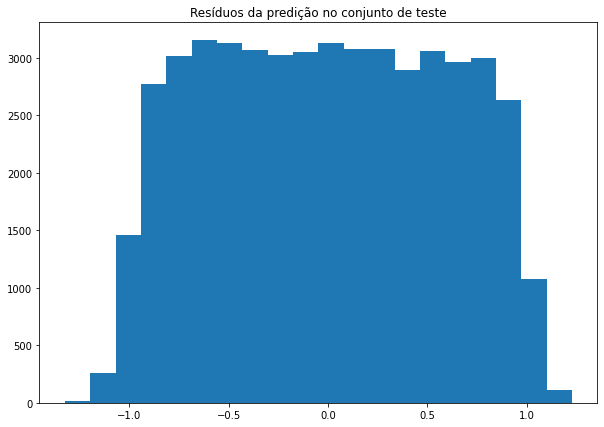

RMSE de teste do modelo é:  0.585


In [ ]:
# score do modelo: RMSE de teste
rmse = lf.score(plot_residual=True)
print(f"RMSE de teste do modelo é: {rmse: .3f}")

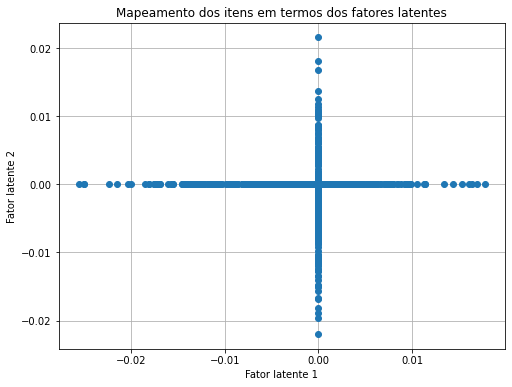

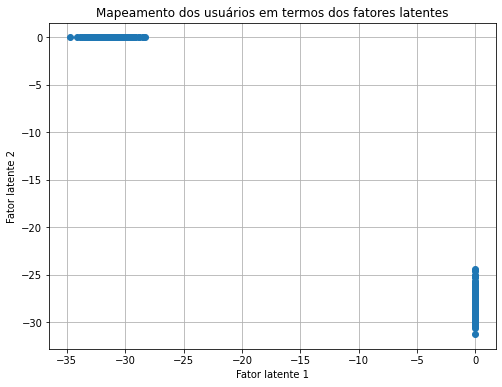

In [ ]:
# plota mapeamento de fatores latentes
lf.plot_embeddings()

In [ ]:
# predição no conjunto de teste
predictions = pd.DataFrame({'y_test': lf.ratings_test, 'y_pred': lf.y_pred})

In [ ]:
# TOP 10 predições
predictions.sort_values(by='y_pred', ascending=False).head(10)

,y_test,y_pred
34329,3.943935,4.377920
33322,3.519180,4.376043
17543,4.448991,4.367840
46380,4.448991,4.367840
2686,3.388259,4.342420
9299,4.579733,4.336473
17177,3.011321,4.336047
6358,4.578274,4.335960
25764,4.987515,4.335165
7330,4.987515,4.335165


In [ ]:
# BOTTOM 10 predições
predictions.sort_values(by='y_pred').head(10)

,y_test,y_pred
25010,4.251996,3.677915
26417,3.368883,3.682666
36055,4.013759,3.684122
22450,4.893540,3.687692
35818,3.629195,3.687819
19633,3.143674,3.692773
12117,3.370446,3.696481
9373,3.663402,3.700030
1634,3.827284,3.700916
205,4.496499,3.701158


## Problema real

In [ ]:
# leitura dos dados
df_ratings = pd.read_csv("https://pycourse.s3.amazonaws.com/ratings_small.csv")
df_ratings.drop_duplicates(inplace=True)
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
# matriz de avaliações
R = df_ratings.pivot(columns='movieId', index='userId', values='rating')
R

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,...,155820,156025,156387,156607,156609,156726,157200,157296,157407,157667,158238,158314,158528,158956,159093,159462,159690,159755,159858,159972,160080,160271,160438,160440,160563,160565,160567,160590,160656,160718,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# pré-processando a matriz: substituindo NaN por 0
R = R.fillna(0)

In [ ]:
R

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,35,36,37,38,39,40,41,...,155820,156025,156387,156607,156609,156726,157200,157296,157407,157667,158238,158314,158528,158956,159093,159462,159690,159755,159858,159972,160080,160271,160438,160440,160563,160565,160567,160590,160656,160718,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# algoritmo Latent Factor
lf = LatentFactor(R.values,
                  p_reg=0.04,
                  test_size=0.2,
                  lr=.95,
                  n_iter=80)

In [ ]:
# treina o modelo
lf.fit(verbose = True)

Número de fatores latentes: 115
Iteração 1 de 80... test rmse 1.123, lr 0.9500
Iteração 2 de 80... test rmse 1.102, lr 0.9500
Iteração 3 de 80... test rmse 1.100, lr 0.9500
Iteração 4 de 80... test rmse 1.103, lr 0.9500
Iteração 5 de 80... test rmse 1.106, lr 0.9500
Iteração 6 de 80... test rmse 1.060, lr 0.7125
Iteração 7 de 80... test rmse 1.062, lr 0.7125
Iteração 8 de 80... test rmse 1.053, lr 0.7125
Iteração 9 de 80... test rmse 1.058, lr 0.7125
Iteração 10 de 80... test rmse 1.055, lr 0.7125
Iteração 11 de 80... test rmse 1.037, lr 0.5344
Iteração 12 de 80... test rmse 1.032, lr 0.5344
Iteração 13 de 80... test rmse 1.034, lr 0.5344
Iteração 14 de 80... test rmse 1.030, lr 0.5344
Iteração 15 de 80... test rmse 1.034, lr 0.5344
Iteração 16 de 80... test rmse 1.020, lr 0.4008
Iteração 17 de 80... test rmse 1.020, lr 0.4008
Iteração 18 de 80... test rmse 1.018, lr 0.4008
Iteração 19 de 80... test rmse 1.018, lr 0.4008
Iteração 20 de 80... test rmse 1.017, lr 0.4008
Iteração 21 de 80

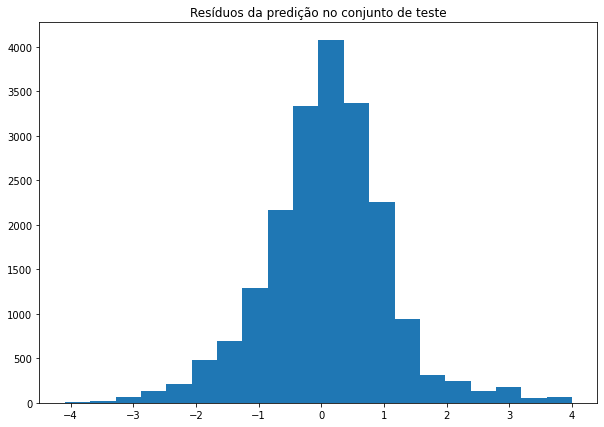

RMSE de teste do modelo é:  0.991


In [ ]:
# score do modelo: RMSE de teste
rmse = lf.score(plot_residual=True)
print(f"RMSE de teste do modelo é: {rmse: .3f}")

# Referências

* [surpriselib](http://surpriselib.com/)
* [lightFM](https://making.lyst.com/lightfm/docs/index.html)
* [From the Labs: Winning the Netflix Prize](https://youtu.be/ImpV70uLxyw)